In [2]:
from typing import Optional, Dict, Any
import numpy as np
from filelock import FileLock
import pathlib
import pandas as pd
from itertools import product

import os
os.chdir("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction")
from src.cate.data.data_class import CATETrainDataSet, CATETestDataSet
from src.utils.kernel_func import AbsKernel, GaussianKernel, BinaryKernel
from src.utils import cal_loocv, cal_loocv_emb, cal_loocv_with_cluster

from matplotlib import pyplot

c:\Users\liuch\miniconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\liuch\AppData\Local\Temp\ipykernel_18320\1280097207.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Binarized Treatment

In [26]:
def get_kernel_func(data_name: str) -> [AbsKernel, AbsKernel, AbsKernel]:
    if data_name == "job_corp":
        return GaussianKernel(), BinaryKernel(), GaussianKernel()
    elif data_name == "synthetic":
        return GaussianKernel(), BinaryKernel(), GaussianKernel()
    else:
        return GaussianKernel(), GaussianKernel(), GaussianKernel()


class BackDoorMeanEmbedding:
    treatment_kernel_func: AbsKernel
    covariate_kernel_func: AbsKernel
    train_treatment: np.ndarray
    train_covariate: np.ndarray
    kernel_mat: np.ndarray
    cov_kernel_mat: np.ndarray
    backdoor_kernel: np.ndarray
    outcome: np.ndarray

    def __init__(self, lam1, lam2, **kwargs):
        self.lam1 = lam1
        self.lam2 = lam2

    def fit(self, train_data: CATETrainDataSet, data_name: str):
        self.train_treatment = np.array(train_data.treatment, copy=True)
        self.outcome = np.array(train_data.outcome, copy=True)
        self.train_covariate = np.array(train_data.covariate, copy=True)

        funcs = get_kernel_func(data_name)
        backdoor_kernel_func = funcs[0]
        self.treatment_kernel_func = funcs[1]
        self.covariate_kernel_func = funcs[2]

        backdoor_kernel_func.fit(train_data.backdoor, )
        self.treatment_kernel_func.fit(train_data.treatment, )
        self.covariate_kernel_func.fit(train_data.covariate, )

        treatment_kernel = self.treatment_kernel_func.cal_kernel_mat(train_data.treatment, train_data.treatment)
        self.backdoor_kernel = backdoor_kernel_func.cal_kernel_mat(train_data.backdoor, train_data.backdoor)
        covariate_kernel = self.covariate_kernel_func.cal_kernel_mat(train_data.covariate, train_data.covariate)

        all_kernel_mat = covariate_kernel * treatment_kernel * self.backdoor_kernel
        if isinstance(self.lam1, list):
            score = [cal_loocv(all_kernel_mat, self.outcome, reg) for reg in self.lam1]
            self.lam1 = self.lam1[np.argmin(score)]
            print(self.lam1)

        if isinstance(self.lam2, list):
            score = [cal_loocv_emb(covariate_kernel, self.backdoor_kernel, reg) for reg in self.lam2]
            self.lam2 = self.lam2[np.argmin(score)]
            print(self.lam2)

        n_data = treatment_kernel.shape[0]
        self.kernel_mat = (all_kernel_mat + n_data * self.lam1 * np.eye(n_data))
        self.cov_kernel_mat = covariate_kernel + n_data * self.lam2 * np.eye(n_data)

    def predict(self, treatment: np.ndarray, covariate: np.ndarray) -> np.ndarray:
        treatment_kernel = self.treatment_kernel_func.cal_kernel_mat(self.train_treatment, treatment)
        cov_kernel = self.covariate_kernel_func.cal_kernel_mat(self.train_covariate, covariate)
        test_kernel = np.linalg.solve(self.cov_kernel_mat, cov_kernel)
        test_kernel = np.dot(self.backdoor_kernel, test_kernel)
        test_kernel = test_kernel * cov_kernel * treatment_kernel
        mat = np.linalg.solve(self.kernel_mat, test_kernel)
        return np.dot(mat.T, self.outcome)

    def evaluate(self, test_data: CATETestDataSet):
        pred = self.predict(treatment=test_data.treatment, covariate=test_data.covariate)
        return np.mean((pred - test_data.structural) ** 2)


def evaluate_mean_embedding(data_config: Dict[str, Any], model_param: Dict[str, Any]):
    train_data = generate_train_jobcorp()
    test_data = generate_test_jobcorp()
    model = BackDoorMeanEmbedding(**model_param)
    model.fit(train_data, data_config["name"])
    if test_data.structural is not None:
        return model.evaluate(test_data)
    else:
        return model.predict(test_data.treatment, test_data.covariate)[:, 0]

def generate_test_jobcorp():
    treatment = np.arange(0, 2)
    covariate = np.linspace(16, 24, 81)
    data = np.array(list(product(treatment, covariate)))
    return CATETestDataSet(treatment=data[:, [0]],
                           covariate=data[:, [1]],
                           structural=None)

def run_test(lam1, lam2):
    env_param = {
        "name": "job_corp",
        "split_type": 3
    }
    mdl_param = {
        "name": "mean_embedding",
        "lam1": lam1,
        "lam2": lam2
    }
    outcome = evaluate_mean_embedding(env_param, mdl_param)
    effect = outcome[81:162] - outcome[0:81]
    pyplot.plot(np.linspace(16, 24, 81), effect)

0.0001
0.001


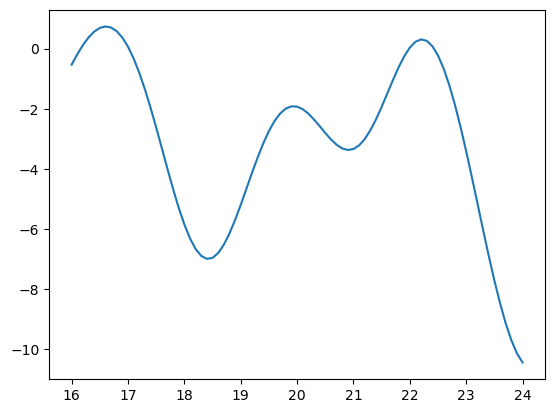

In [27]:
# No subsetting
def generate_train_jobcorp():
    data = pd.read_csv("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction/data/job_corps/JCdata.csv", sep=" ")

    sub = data
    sub.loc[sub["d"] > 0, "d"] = 1
    sub = sub.astype({"d": "int64"})
    outcome = sub["m"].to_numpy()
    treatment = sub["d"].to_numpy()
    covariate = sub["age"].to_numpy()
    backdoor = sub.iloc[:, 3:].drop("age", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
         lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

0.0001
0.001


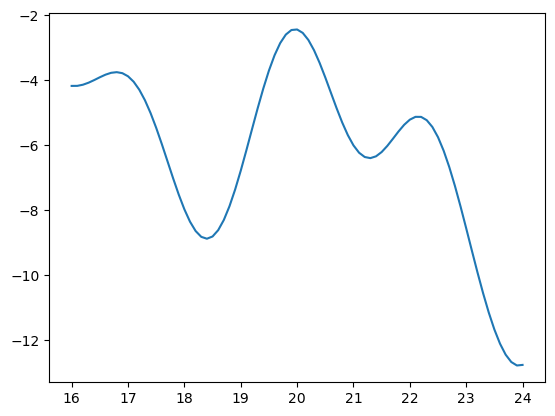

In [28]:
# T is 0 or (0, 500]
def generate_train_jobcorp():
    data = pd.read_csv("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction/data/job_corps/JCdata.csv", sep=" ")

    sub = data.loc[data["d"] <= 500, :]
    sub.loc[sub["d"] > 0, "d"] = 1
    sub = sub.astype({"d": "int64"})
    outcome = sub["m"].to_numpy()
    treatment = sub["d"].to_numpy()
    covariate = sub["age"].to_numpy()
    backdoor = sub.iloc[:, 3:].drop("age", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
         lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

0.0001
0.001


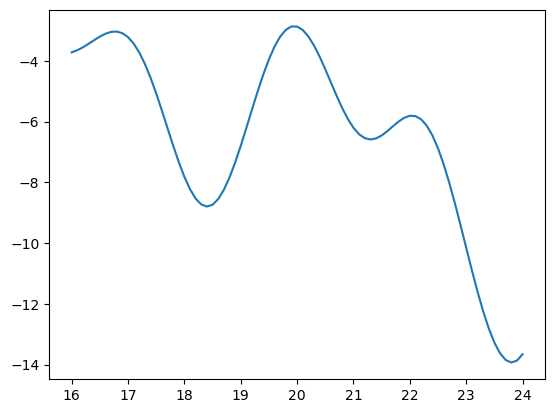

In [29]:
# T is 0 or [40, 500]
def generate_train_jobcorp():
    data = pd.read_csv("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction/data/job_corps/JCdata.csv", sep=" ")

    sub = data.loc[((data["d"] >= 40) & (data["d"] <= 500)) | (data["d"] == 0), :]
    sub.loc[sub["d"] > 0, "d"] = 1
    sub = sub.astype({"d": "int64"})
    outcome = sub["m"].to_numpy()
    treatment = sub["d"].to_numpy()
    covariate = sub["age"].to_numpy()
    backdoor = sub.iloc[:, 3:].drop("age", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
         lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

0.0001
0.001


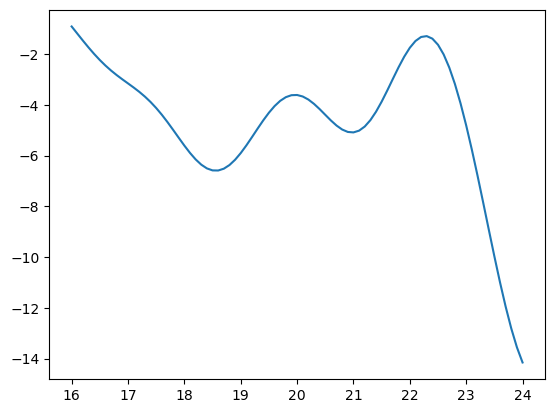

In [30]:
# Y > 0
def generate_train_jobcorp():
    data = pd.read_csv("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction/data/job_corps/JCdata.csv", sep=" ")

    sub = data.loc[data["m"] > 0, :]
    sub.loc[sub["d"] > 0, "d"] = 1
    sub = sub.astype({"d": "int64"})
    outcome = sub["m"].to_numpy()
    treatment = sub["d"].to_numpy()
    covariate = sub["age"].to_numpy()
    backdoor = sub.iloc[:, 3:].drop("age", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
         lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

0.0001
0.001


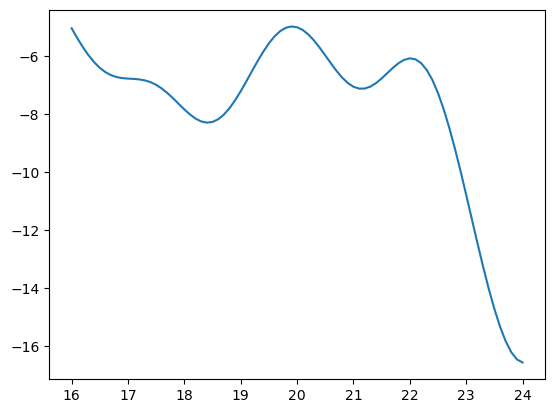

In [31]:
# Y > 0; T is 0 or (0, 500]
def generate_train_jobcorp():
    data = pd.read_csv("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction/data/job_corps/JCdata.csv", sep=" ")

    sub = data.loc[data["m"] > 0, :]
    sub = sub.loc[sub["d"] <= 500, :]
    sub.loc[sub["d"] > 0, "d"] = 1
    sub = sub.astype({"d": "int64"})
    outcome = sub["m"].to_numpy()
    treatment = sub["d"].to_numpy()
    covariate = sub["age"].to_numpy()
    backdoor = sub.iloc[:, 3:].drop("age", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
         lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

0.0001
0.001


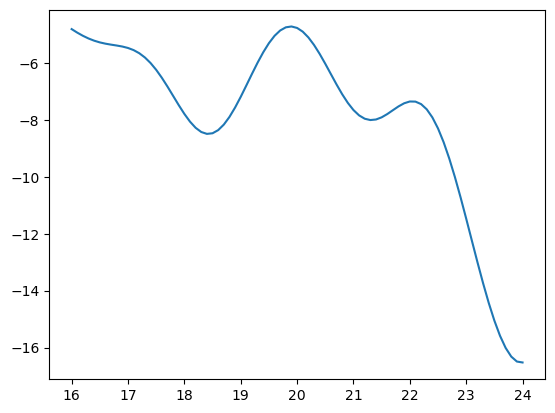

In [32]:
# Y > 0; T is 0 or [40, 500]
def generate_train_jobcorp():
    data = pd.read_csv("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction/data/job_corps/JCdata.csv", sep=" ")

    sub = data.loc[data["m"] > 0, :]
    sub = sub.loc[((sub["d"] >= 40) & (sub["d"] <= 500)) | (sub["d"] == 0), :]
    sub.loc[sub["d"] > 0, "d"] = 1
    sub = sub.astype({"d": "int64"})
    outcome = sub["m"].to_numpy()
    treatment = sub["d"].to_numpy()
    covariate = sub["age"].to_numpy()
    backdoor = sub.iloc[:, 3:].drop("age", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
         lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

Continuous Treatment

In [23]:
def get_kernel_func(data_name: str) -> [AbsKernel, AbsKernel, AbsKernel]:
    if data_name == "job_corp":
        return GaussianKernel(), GaussianKernel(), GaussianKernel()
    elif data_name == "synthetic":
        return GaussianKernel(), BinaryKernel(), GaussianKernel()
    else:
        return GaussianKernel(), GaussianKernel(), GaussianKernel()


class BackDoorMeanEmbedding:
    treatment_kernel_func: AbsKernel
    covariate_kernel_func: AbsKernel
    train_treatment: np.ndarray
    train_covariate: np.ndarray
    kernel_mat: np.ndarray
    cov_kernel_mat: np.ndarray
    backdoor_kernel: np.ndarray
    outcome: np.ndarray

    def __init__(self, lam1, lam2, **kwargs):
        self.lam1 = lam1
        self.lam2 = lam2

    def fit(self, train_data: CATETrainDataSet, data_name: str):
        self.train_treatment = np.array(train_data.treatment, copy=True)
        self.outcome = np.array(train_data.outcome, copy=True)
        self.train_covariate = np.array(train_data.covariate, copy=True)

        funcs = get_kernel_func(data_name)
        backdoor_kernel_func = funcs[0]
        self.treatment_kernel_func = funcs[1]
        self.covariate_kernel_func = funcs[2]

        backdoor_kernel_func.fit(train_data.backdoor, )
        self.treatment_kernel_func.fit(train_data.treatment, )
        self.covariate_kernel_func.fit(train_data.covariate, )

        treatment_kernel = self.treatment_kernel_func.cal_kernel_mat(train_data.treatment, train_data.treatment)
        self.backdoor_kernel = backdoor_kernel_func.cal_kernel_mat(train_data.backdoor, train_data.backdoor)
        covariate_kernel = self.covariate_kernel_func.cal_kernel_mat(train_data.covariate, train_data.covariate)

        all_kernel_mat = covariate_kernel * treatment_kernel * self.backdoor_kernel
        if isinstance(self.lam1, list):
            score = [cal_loocv(all_kernel_mat, self.outcome, reg) for reg in self.lam1]
            self.lam1 = self.lam1[np.argmin(score)]
            print(self.lam1)

        if isinstance(self.lam2, list):
            score = [cal_loocv_emb(covariate_kernel, self.backdoor_kernel, reg) for reg in self.lam2]
            self.lam2 = self.lam2[np.argmin(score)]
            print(self.lam2)

        n_data = treatment_kernel.shape[0]
        self.kernel_mat = (all_kernel_mat + n_data * self.lam1 * np.eye(n_data))
        self.cov_kernel_mat = covariate_kernel + n_data * self.lam2 * np.eye(n_data)

    def predict(self, treatment: np.ndarray, covariate: np.ndarray) -> np.ndarray:
        treatment_kernel = self.treatment_kernel_func.cal_kernel_mat(self.train_treatment, treatment)
        cov_kernel = self.covariate_kernel_func.cal_kernel_mat(self.train_covariate, covariate)
        test_kernel = np.linalg.solve(self.cov_kernel_mat, cov_kernel)
        test_kernel = np.dot(self.backdoor_kernel, test_kernel)
        test_kernel = test_kernel * cov_kernel * treatment_kernel
        mat = np.linalg.solve(self.kernel_mat, test_kernel)
        return np.dot(mat.T, self.outcome)

    def evaluate(self, test_data: CATETestDataSet):
        pred = self.predict(treatment=test_data.treatment, covariate=test_data.covariate)
        return np.mean((pred - test_data.structural) ** 2)


def evaluate_mean_embedding(data_config: Dict[str, Any], model_param: Dict[str, Any]):
    train_data = generate_train_jobcorp()
    test_data = generate_test_jobcorp()
    model = BackDoorMeanEmbedding(**model_param)
    model.fit(train_data, data_config["name"])
    if test_data.structural is not None:
        return model.evaluate(test_data)
    else:
        return model.predict(test_data.treatment, test_data.covariate)[:, 0]

def generate_train_jobcorp():
    data = pd.read_csv("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction/data/job_corps/JCdata.csv", sep=" ")

    sub = data.loc[data["m"] > 0, :]
    sub = sub.loc[sub["d"] >= 40, :]
    outcome = sub["m"].to_numpy()
    treatment = sub["d"].to_numpy()
    covariate = sub["age"].to_numpy()
    backdoor = sub.iloc[:, 3:].drop("age", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

def generate_test_jobcorp():
    treatment = np.linspace(40, 2500, 1000)
    covariate = np.linspace(16, 24, 81)
    data = np.array(list(product(treatment, covariate)))
    return CATETestDataSet(treatment=data[:, [0]],
                           covariate=data[:, [1]],
                           structural=None)

def run_test(lam1, lam2):
    env_param = {
        "name": "job_corp",
        "split_type": 3
    }
    mdl_param = {
        "name": "mean_embedding",
        "lam1": lam1,
        "lam2": lam2
    }
    outcome = evaluate_mean_embedding(env_param, mdl_param)
    outcome = np.reshape(outcome, (81, 1000), order = "F")

    fig, ax = pyplot.subplots()
    CS = ax.contour(np.linspace(40, 2500, 1000), np.linspace(16, 24, 81), outcome)
    ax.clabel(CS, inline=True, fontsize=10)

0.0005
0.001


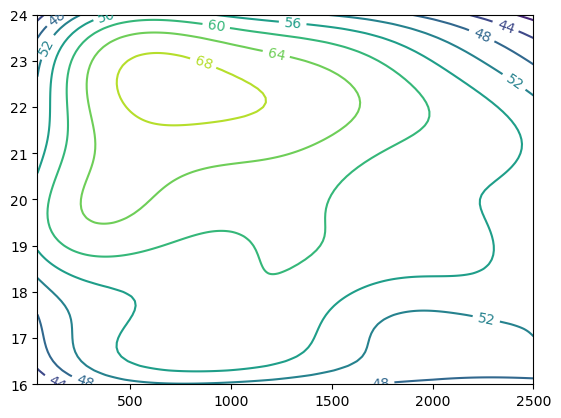

In [24]:
run_test(lam1 = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
         lam2 = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])